<a href="https://colab.research.google.com/github/Dina-Nabil/MURA/blob/master/MURA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!ls "/content/drive/My Drive/MURA-v1.1"

In [0]:
from keras.applications import densenet, mobilenet, vgg16, inception_v3
from keras.models import Model
from keras.layers import Dense, Activation, concatenate
from keras import optimizers,losses
from keras.utils import np_utils
from sklearn.utils import shuffle
import numpy as np
from PIL import Image ,ImageOps
import matplotlib.pyplot as plt
import cv2 as cv
import os
from tqdm import tqdm
import pandas as pd
import seaborn as sb
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# **Visualization**

In [0]:
PATH="/content/drive/My Drive/MURA-v1.1/Edited_CSV"
os.listdir(PATH)

['train_labeled_studies.csv',
 'valid_image_paths.csv',
 'valid_labeled_studies.csv',
 'train_image_paths.csv']

In [0]:
train_imgs_path=pd.read_csv(PATH+'/train_image_paths.csv')
train_labels=pd.read_csv(PATH+'/train_labeled_studies.csv')
test_imgs_path=pd.read_csv(PATH+'/valid_image_paths.csv')
test_labels=pd.read_csv(PATH+'/valid_labeled_studies.csv')

In [0]:
train_imgs_path.head()

,Path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [0]:
train_imgs_path.shape[0]

36808

In [0]:
train_labels.head()

,Path,Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [0]:
train_labels['Label'].value_counts()

0    8280
1    5177
Name: Label, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


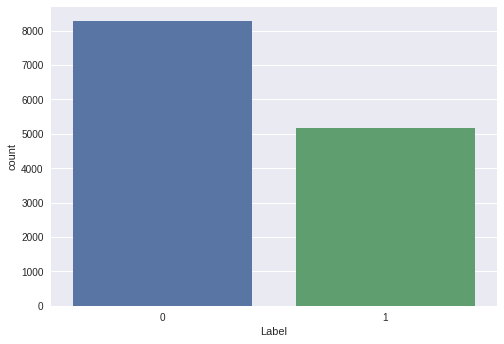

In [0]:
import seaborn as sns
sns.countplot(train_labels['Label'])

In [0]:
train_labels['Studies']=train_labels['Path'].apply(lambda x: str(x.split('/')[2])[3:])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


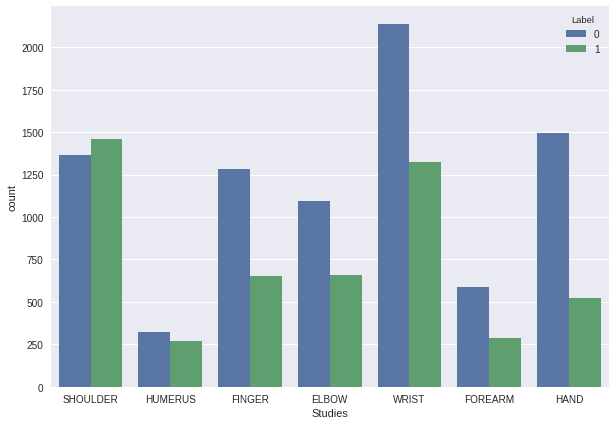

In [0]:
plt.figure(figsize=(10,7))
sns.countplot(x='Studies',hue='Label',data=train_labels)

In [0]:
test_imgs_path.head()

,Path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...


In [0]:
test_imgs_path.shape[0]

3197

In [0]:
test_labels.head()

,Path,Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1


In [0]:
test_labels['Label'].value_counts()

0    661
1    538
Name: Label, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


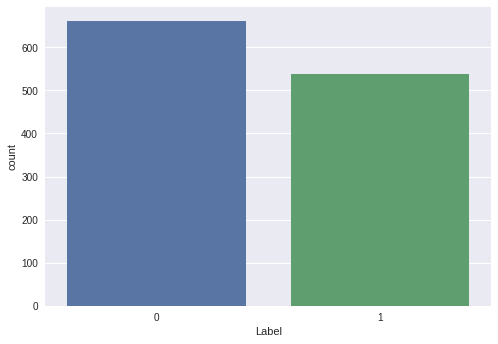

In [0]:
sns.countplot(test_labels['Label'])

In [0]:
test_labels['Studies']=test_labels['Path'].apply(lambda x: str(x.split('/')[2])[3:])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


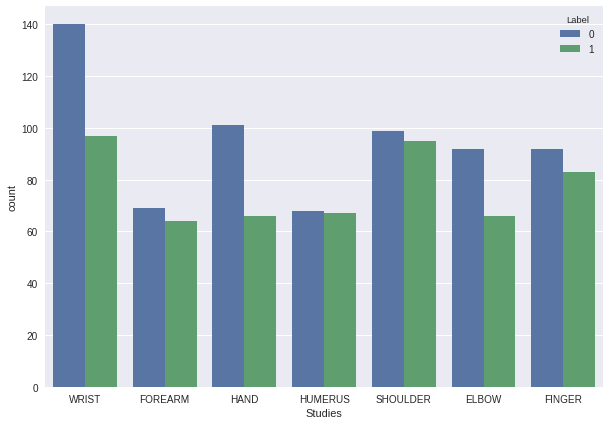

In [0]:
plt.figure(figsize=(10,7))
sns.countplot(x='Studies',hue='Label',data=test_labels)

# **Load Data**

In [0]:
def get_study_level_data(study_type):
    """
    Returns a dict, with keys 'train' and 'valid' and respective values as study level dataframes, 
    these dataframes contain three columns 'Path', 'Count', 'Label'
    Args:
        study_type (string): one of the seven study type folder names in 'train/valid/test' dataset 
    """
    data_cat = ['train', 'valid']
    study_data = {}
    study_label = {'positive': 1, 'negative': 0}
    for phase in data_cat:
        BASE_DIR = '/content/drive/My Drive/MURA-v1.1/%s/%s/' % (phase , study_type)
        patients = list(os.walk(BASE_DIR))[0][1] # list of patient folder names
        study_data[phase] = pd.DataFrame(columns=['Path', 'Count', 'Label'])
        i = 0
        for patient in tqdm(patients): # for each patient folder
            for study in os.listdir(BASE_DIR + patient): # for each study in that patient folder
                label = study_label[study.split('_')[1]] # get label 0 or 1
                path = BASE_DIR + patient + '/' + study + '/' # path to this study
                study_data[phase].loc[i] = [path, len(os.listdir(path)), label] # add new row
                i+=1
    return study_data

In [0]:
def load_training_data(size_x,size_y):
  images_train=[]
  labels_train=[]
  for idx in tqdm(range(study_data['train'].shape[0])):
    study_path = study_data['train'].iloc[idx, 0]
    count = study_data['train'].iloc[idx, 1]
    for i in range(count):
        img=Image.open(study_path + 'image%s.png' % (i+1))
        re_img=img.resize((size_x,size_y))
        re_img=np.array(re_img)
#         re_img =preprocess_input(re_img)
        if len(re_img.shape)< 3:
          re_img=cv.cvtColor(re_img,cv.COLOR_GRAY2RGB)
        images_train.append( re_img)
        labelimg=study_data['train'].iloc[idx, 2]    
        labelimg=np.array(labelimg)
        labels_train.append(labelimg)
  images_train=np.array(images_train)
  labels_train=np.array(labels_train)
  return images_train,labels_train

In [0]:
def load_test_data(size_x,size_y):
  images_test=[]
  labels_test=[]
  for idx in tqdm(range(study_data['valid'].shape[0])):
    study_path = study_data['valid'].iloc[idx, 0]
    count = study_data['valid'].iloc[idx, 1]
    for i in range(count):
        img=Image.open(study_path + 'image%s.png' % (i+1))
        re_img=img.resize((size_x,size_y))
        re_img=np.array(re_img)
#         re_img = preprocess_input(re_img)
        if len(re_img.shape)< 3:
          re_img=cv.cvtColor(re_img,cv.COLOR_GRAY2RGB)
        images_test.append(re_img)
        labelimg=study_data['valid'].iloc[idx, 2]
        labelimg=np.array(labelimg)
        labels_test.append(labelimg)
  images_test=np.array(images_test)
  labels_test=np.array(labels_test) 
  return images_test,labels_test

In [0]:
study_data=get_study_level_data('XR_HUMERUS')

In [0]:
study_data

In [0]:
images_train,labels_train=load_training_data(224,224)

In [0]:
images_test,labels_test =load_test_data(224,224)

In [0]:
images_train,labels_train=shuffle(images_train,labels_train,random_state=4)

In [0]:
labels_train_cat = np_utils.to_categorical(labels_train, 2)
labels_test_cat = np_utils.to_categorical(labels_test, 2)

# **Data Augmentation**

In [0]:
train_datagen=ImageDataGenerator( featurewise_center=True,featurewise_std_normalization=True,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,
                                    horizontal_flip=True,validation_split=0.2)

In [0]:
def fit_Augmentaion(model):
  model.fit_generator(train_datagen.flow(x=images_train,y=labels_train_cat,batch_size=32),epochs=5,steps_per_epoch=(images_train.shape[0] // 32))

# **Functions**

In [0]:
def compile(model):
  model.compile(optimizers.Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
def fit(model):
  model.fit(x=images_train,y=labels_train_cat,batch_size=32,epochs=5,validation_split=0.2)

In [0]:
def evaluate(model):
  test_eval = model.evaluate(x=images_test, y=labels_test_cat, verbose=0)
  print('Test loss:', test_eval[0])
  print('Test accuracy:', test_eval[1])

In [0]:
def predict(model):
  predictions=model.predict(images_test,verbose=1)
  return predictions

In [0]:
def plot_confusion_matrix(prediction):
  print("classification_report :  \n ", classification_report(np.argmax(labels_test_cat,axis=1),np.argmax(prediction,axis=1)))
  accuracy = accuracy_score(np.argmax(labels_test_cat,axis=1), np.argmax(prediction,axis=1))
  print(f'accuracy: {accuracy}')
  cm = pd.DataFrame(confusion_matrix(np.argmax(labels_test_cat,axis=1), np.argmax(prediction,axis=1)))
  sb.heatmap(cm,annot=True)
  plt.show()

# **DenseNet**

In [0]:
def DenseNetModel():
  dense = densenet.DenseNet169()
  dense.summary()
  x = dense.layers[-2].output
  predictions = Dense(2,activation = 'softmax')(x)
  model = Model(inputs=dense.input, outputs=predictions)
  model.summary()
  compile(model)
  return model

Model

In [0]:
dense_model=DenseNetModel()

Train

In [0]:
fit(dense_model)

In [0]:
fit_Augmentaion(dense_model)

Test

In [0]:
evaluate(dense_model)

Predict

In [0]:
dense_predictions=predict(dense_model)
print(dense_predictions[250])
print(labels_test_cat[250])

Confusion Matrix

In [0]:
plot_confusion_matrix(dense_predictions)

# **MobileNet**

In [0]:
def MobileNetModel():
  mobile = mobilenet.MobileNet()
  mobile.summary()
  x = mobile.layers[-6].output
  predictions = Dense(2,activation = 'softmax')(x)
  model = Model(inputs=mobile.input, outputs=predictions)
  model.summary()
  compile(model)
  return model

Model

In [0]:
 mobile_model=MobileNetModel()

Train

In [0]:
fit(mobile_model)

In [0]:
fit_Augmentaion(mobile_model)

Test

In [0]:
evaluate(mobile_model)

Predict

In [0]:
mobile_predictions=predict(mobile_model)
print(mobile_predictions[250])
print(labels_test_cat[250])

Confusion Matrix

In [0]:
plot_confusion_matrix(mobile_predictions)

# **VGG**

Model

In [0]:
def VGG():
  vgg =vgg16.VGG16()
  vgg.summary()
  x = vgg.layers[-4].output
  predictions = Dense(2,activation = 'softmax')(x)
  model = Model(inputs=vgg.input, outputs=predictions)
  model.summary()
  compile(model)
  return model

In [0]:
vgg_model=VGG()

Train

In [0]:
fit(vgg_model)

In [0]:
fit_Augmentaion(vgg_model)

Test

In [0]:
evaluate(vgg_model)

Predict

In [0]:
vgg_predictions=predict(vgg_model)
print(vgg_predictions[250])
print(labels_test_cat[250])

Confusion Matrix

In [0]:
plot_confusion_matrix(vgg_predictions)

# **Inception**

Model

In [0]:
def Inception():
  inception = inception_v3.InceptionV3()
  inception.summary()
  x = inception.layers[-2].output
  predictions = Dense(2,activation = 'softmax')(x)
  model = Model(inputs=inception.input, outputs=predictions)
  model.summary()
  compile(model)
  return model

In [0]:
inception_model=Inception()

Train

In [0]:
fit(inception_model)

In [0]:
fit_Augmentaion(inception_model)

Test

In [0]:
evaluate(inception_model)

Predict

In [0]:
inception_predictions=predict(inception_model)
print(inception_predictions[250])
print(labels_test_cat[250])

Confusion Matrix

In [0]:
plot_confusion_matrix(inception_predictions)

# **Voting**

In [0]:
def vote(predictions1,predictions2,predictions3):
  test_size=predictions1.shape[0]
  predictions=np.empty([test_size,2])
  for i in range(test_size):
    votes=np.argmax(predictions1[i])+np.argmax(predictions2[i])+np.argmax(predictions3[i])
    if(votes<=1):
      predictions[i]=[1,0]
    else:
      predictions[i]=[0,1]
  return predictions

In [0]:
predictions=vote(dense_predictions,pred_mobile_dense,pred_mobile_dense_vgg)

In [0]:
plot_confusion_matrix(predictions) 

#**Feature Extraction **


In [0]:
def mobile_dense():
  mobile = mobilenet.MobileNet(include_top=False,pooling='avg')
  dense=densenet.DenseNet169(include_top=False,pooling='avg')
  conc = concatenate([mobile.output, dense.output])
  predictions = Dense(2,activation = 'softmax')(conc)
  model = Model(inputs=[mobile.input,dense.input], outputs=predictions)
  model.summary()
  return model

In [0]:
mobile_dense=mobile_dense()

In [0]:
mobile_dense.compile(optimizers.Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
mobile_dense.fit(x=[images_train,images_train],y=labels_train_cat,batch_size=10,epochs=5,validation_split=0.2)

In [0]:
eval_mobile_dense = mobile_dense.evaluate(x=[images_test,images_test], y=labels_test_cat, verbose=0)
print('Test loss:', eval_mobile_dense[0])
print('Test accuracy:', eval_mobile_dense[1])

In [0]:
pred_mobile_dense=mobile_dense.predict([images_test,images_test])

In [0]:
plot_confusion_matrix(pred_mobile_dense)

In [0]:
def mobile_dense_vgg():
  mobile = mobilenet.MobileNet(include_top=False,pooling='avg')
  dense=densenet.DenseNet169(include_top=False,pooling='avg')
  vgg =vgg16.VGG16()
  x = vgg.layers[-4].output
  conc1 = concatenate([mobile.output, dense.output])
  conc2 = concatenate([conc1 , x])
  predictions = Dense(2,activation = 'softmax')(conc2)
  model = Model(inputs=[mobile.input,dense.input,vgg.input], outputs=predictions)
  model.summary()
  return model

In [0]:
mobile_dense_vgg = mobile_dense_vgg()

In [0]:
mobile_dense_vgg.compile(optimizers.Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
mobile_dense_vgg.fit(x=[images_train,images_train,images_train],y=labels_train_cat,batch_size=10,epochs=5,validation_split=0.2)

In [0]:
eval_mobile_dense_vgg = mobile_dense_vgg.evaluate(x=[images_test,images_test,images_test], y=labels_test_cat, verbose=0)
print('Test loss:', eval_mobile_dense_vgg[0])
print('Test accuracy:', eval_mobile_dense_vgg[1])

In [0]:
pred_mobile_dense_vgg=mobile_dense_vgg.predict([images_test,images_test,images_test])

In [0]:
plot_confusion_matrix(pred_mobile_dense_vgg)